# Data Science ISM: The Recipe for a winning Basketball Team 

What makes a basketball team win a championship? The weather? The connection the teammates have? The volume with which the crowd chants their names? Perhaps all these things play a part into whether a particular player sinks that 3 that puts them ahead. However, it's a bit difficult to consider all those variables, so I'll be using statistics that have been known to provide meaningful information on basketball teams. 

<img src="Photos/MJ_Pic.jpg" style="height: 250px; width:150px;"/>

First I will analyze the years in which two basketball teams won the championship. One is the Chicago Bulls from the 90s, and the other is the 2010s Golden State Warriors. Both teams were at one point dominant powerhouses. By using k-means clustering, we can determine what kind of players exist in these teams. 

From this, a coach who is trying to build a team like the Chicago Bulls or the Golden State warriors, or any other team in general, can use this to find what players they have that fit the requirement, and which ones they should exchange/trade. 

In [4]:
# input the years for which you want to access the data
import os
# url for the teams in general 

In [5]:
# Web Scraping

# # gets you the data and stores it in the Storage file 
# # This is so we dont DDoS the website

import requests
# Teams = ["CHI", "GSW"] # A list of the TeamName= 1

def WebScraper(years, TeamName): 
    url_start = "https://www.basketball-reference.com/teams/" + TeamName + "/{}.html"
    for year in years: 
        url = url_start.format(year)
        dir =  "Storage/" + TeamName +"/{}.html".format(year)
        if os.path.exists(dir):
            print("Already loaded the data")
        else: 
            if os.path.exists("Storage/" + TeamName) == False: 
                os.makedirs("Storage/" + TeamName)
            data = requests.get(url)
            f = open("Storage/" + TeamName + "/{}.html".format(year), "w+", encoding="utf-8")
            f.write(data.text)
            print("New File Added")
    
# # Uncomment only when years changes

In [62]:
# select dataframe based on the title 
# Adding a year column so we know which year the players are done

import pandas as pd 
from bs4 import BeautifulSoup

def GetTeamData(TeamName, years): 
    pergame_table = []
    # TeamName = "CHI" # put in the team name 
    for i in years:
        if os.path.exists("Storage/" + TeamName +"/{}.html".format(i)) == False:
            WebScraper([i], TeamName) 
        with open("Storage/" + TeamName +"/{}.html".format(i), encoding = "utf-8") as f:  
            page = f.read()
            soup = BeautifulSoup(page, "html.parser") # creates a parser class that will help us extract the html code from the page
            pergame = soup.find(id="per_game") # Reads data from the per_game id. 
            pd.read_html(str(pergame))[0]
            df = pd.read_html(str(pergame))[0]
            df.insert(0, "Year", i)
            # append the data frame to a list so that we have a list of dataframes for the pergame data
            pergame_table.append(df)
    # BigData = pd.concat(pergame_table) # a variable that stores the data for every table. 
    return pergame_table

These are the different stats that we now have access to: 
 
 Index(['Year', 'Rk', 'Unnamed: 1', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS/G'],
      dtype='object')

In [63]:
# Function to easily find the relavent stats that are required and return it as a dataframe

def FindStats(df): 
    names = df["Unnamed: 1"]
    Steals = df["STL"]
    Assist = df["AST"]
    Blocks = df["BLK"]
    pointsPerGame = df["PTS/G"]
    Rebounds = df["TRB"]
    year = df["Year"]
    dict = {"Year": year, "Names": names, "Steals": Steals , "Assists": Assist, "Points":pointsPerGame,
     "Blocks": Blocks, "Rebounds": Rebounds}
    return pd.DataFrame(dict)

# Lets plot the data where it's easy 

# lists out the stats of a particular player
def PlayerData(name, pergame_table): # Takes in the player name and a list of dataframes
   pg = pergame_table[0]
#    pg = pergame_table
   res = pg.loc[pg['Unnamed: 1'] == name] # find the locations where the name is
   for i in range(1, len(pergame_table)):
      pg = pergame_table[i]
      a = pg.loc[pg['Unnamed: 1'] == name] 
      res = pd.concat([res, a])         # return it
   return res # returns the ones with all the values in them 
   
# n = ChicagoBullsData[0] # get the first list
# NameList = n["Unnamed: 1"] # get the first stats: 

# playerlist = []
# for i in NameList: 
#    playerlist.append(PlayerData(str(i), ChicagoBullsData))

In [8]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy
from sklearn.cluster import KMeans

def GetClusters(TeamName, A, plot = False): 
    dict = {"Names:": A["Names"], "Points": A["Points"], "Assists": A["Assists"],  "Rebounds": A["Rebounds"]}
    df = pd.DataFrame(dict)
    X = list(zip(A["Points"],A["Assists"], A["Rebounds"]))
    km = KMeans(5)
    clusts = km.fit_predict(X)

    if plot == False: 
        return km.cluster_centers_, clusts

    else: 
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(km.cluster_centers_[:, 0],
                    km.cluster_centers_[:, 1],
                    km.cluster_centers_[:, 2],
                    s = 250,
                    marker='o',
                    c='red',
                    label='centroids')
        scatter = ax.scatter(df['Points'],df['Assists'], df['Rebounds'],
                            c=clusts,s=20, cmap='winter')

        ax.set_xlabel("Points")
        ax.set_ylabel("Assists")
        ax.set_zlabel("Rebounds")
        ax.set_title("Clustering for " + str(TeamName))

        return km.cluster_centers_, clusts


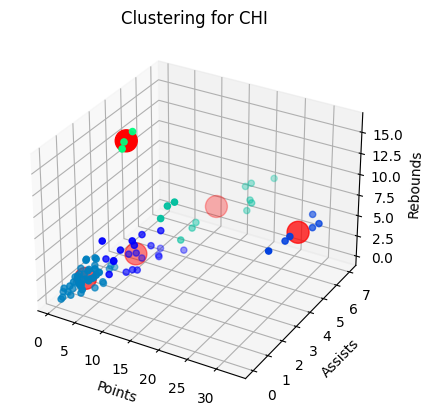

In [9]:
TeamName = "CHI"
years = [1991, 1992, 1993, 1996, 1997, 1998] 
Data = GetTeamData(TeamName, years)
BigData = pd.concat(Data)
TeamStats = FindStats(BigData)
posCHI, clustsCHI = GetClusters(TeamName, TeamStats, plot = True) 

df = BigData
dfbulls = TeamStats
df["Label"] = clustsCHI
dfbulls["Label"] = clustsCHI
a = df.loc[df['Label'] == 1] 


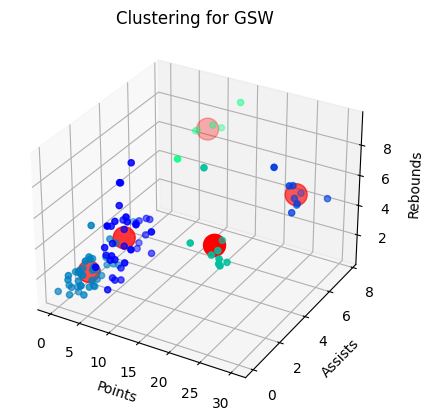

In [10]:
TeamName = "GSW"
years = [2015, 2016, 2017, 2018, 2019, 2022]
Data = GetTeamData(TeamName, years)
BigData = pd.concat(Data)
TeamStats = FindStats(BigData)
dfGSW = TeamStats
posGSW, clustsGSW = GetClusters(TeamName, TeamStats, plot = True) 



In [11]:
nposCHI = [None] * 5
import numpy as np

def dist(X, Y): 
    return np.sqrt((X[0] - Y[0])**2 + (X[1] - Y[1])**2 + (X[2] - Y[2])**2)

In [12]:
distList = []
for i in posCHI: 
    for j in posGSW: 
        distList.append([i, j, dist(i, j)])

NewList = []

In [13]:
for i in range(5): 
    first = np.array(distList[i*5: (i+1) * 5], dtype = "object")
    m = np.amin(first[:, 2])
    idx = np.where(first[:, 2] ==  m)[0]
    NewEntry = [(first[:, 0][idx], first[:, 1][idx], first[:, 2][idx])]
    if NewEntry[0] not in NewList:
        NewList.append(NewEntry[0])
    else: 
        print("no")

/tmp/ipykernel_25568/4251328737.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if NewEntry[0] not in NewList:


In [14]:
c = []
for i in NewList: 
    a, b, d = i 
    c.append([a[0], b[0], d[0]])

In [15]:
bullsDat = []
gswDat = []
diffDat = []

for i in range(5): 
    bullsDat.append(c[i][0])
    gswDat.append(c[i][1])
    diffDat.append(c[i][2])

In [16]:
bullsDat = np.array(bullsDat)
gswDat = np.array(gswDat)
diffDat = np.array(diffDat) 

In [17]:
dict = {"bPoints": bullsDat[:, 0], "gPoints": gswDat[:, 0], "bAssists": bullsDat[:, 1], 
"gAssists": gswDat[:, 1], "bRebounds": bullsDat[:, 2], "gRebounds": gswDat[:, 2]}

In [18]:
sorted = pd.DataFrame(dict)
sorted["Name"] = [0, 1, 2, 3, 4]
sorted["Distance"] = diffDat
A = sorted

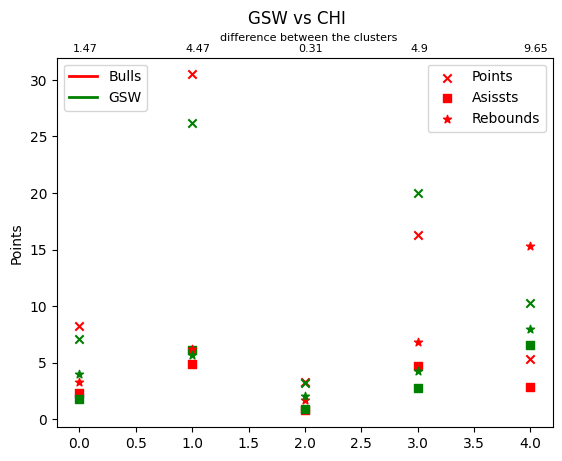

In [19]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color= "red", lw=2),
                Line2D([0], [0], color= "green", lw=2)]

fig, ax = plt.subplots()

plt.scatter( A["Name"], A["bPoints"], color = "red", marker = "x", label = "Points")
plt.scatter( A["Name"], A["gPoints"], color = "green", marker = "x")

plt.scatter( A["Name"], A["bAssists"], color = "red",marker = "s", label = "Asissts")
plt.scatter( A["Name"], A["gAssists"], color = "green", marker = "s")

plt.scatter( A["Name"], A["bRebounds"], color = "red",marker = "*", label = "Rebounds")
plt.scatter( A["Name"], A["gRebounds"], color = "green",marker = "*")

plt.ylabel("Points")
plt.suptitle("GSW vs CHI")
first_legend = plt.legend(loc = 'upper right')
plt.gca().add_artist(first_legend)
plt.legend(custom_lines, ['Bulls', 'GSW'], loc = 'upper left')
plt.text(1.25, 33.5, "difference between the clusters", fontsize = 8)
for i in range(5): 
    plt.text(i - 0.06, 33- 0.5, str(np.round(diffDat[i], 2)), fontsize = 8)

From the above visualization we can determine that while on the large the teams were not very different from each other. Each cluster can be considered to be a unique player on the team. Here are some interesting deductions: 

1. The cluster with the largest displarity shows the CHI having a siginificant lead on rebounds over GSW. 
2. GSW has 3 clusters which average over 10 points a game, wheras the Bulls have 2. This could be inferred to mean that GSW has more point-making players available. 
3. The assists are more or less consistent across the two teams. 

# The Use Case

The use case for this particular clustering model is as follows: Say we have a team which wants to perform as close to the level of the chicago bulls, or golden state warriors, or any other team. Now using the clustering algorithm, we have the "theoretical" positions that one must obtain to get that level of player. 

We can now find the closest match we have to that player. It could be that the ideal player is currently a bench warmer. 

In [54]:
import random 
import numpy 

# Generating Assits, points and rebounds for a random team

A = []
P = []
R = []

for i in range(5): A.append(numpy.round(random.random() *12, 0))
for i in range(5): P.append(numpy.round(random.random() *30, 0))
for i in range(5): R.append(numpy.round(random.random() *20, 0))

In [55]:
# Creating a hypothetical team 

weird_team = {"Names": ["one", "two", "three", "four", "five"], "Assists": A, "Points": P, "Rebounds": R}
weird_team = pd.DataFrame(weird_team)
Assists = weird_team["Assists"]
Points = weird_team["Points"]
Rebounds = weird_team["Rebounds"]

fullPerson = list(zip(Points, Assists, Rebounds))

weird_team

,Names,Assists,Points,Rebounds
0,one,10.0,1.0,7.0
1,two,11.0,1.0,3.0
2,three,12.0,18.0,12.0
3,four,1.0,11.0,8.0
4,five,1.0,2.0,18.0


In [59]:
count = -1
count2 = -1
typeOfExistingPlayer = []
for i in fullPerson:
    count+=1 
    Dlist = []
    for j in posCHI: 
        count2 +=1 
        Dlist.append(dist(i, j))
    print(np.amin(Dlist), count, np.where(Dlist == np.amin(Dlist))[0])
    typeOfExistingPlayer.append(np.where(Dlist == np.amin(Dlist))[0])


10.873587816355741 0 [2]
10.56195587947611 1 [2]
9.093110181768271 2 [3]
5.590472134337784 3 [0]
4.621928409465276 4 [4]


In [57]:
missingPlayer = []
listOfPlayer = []
for i in range(len(typeOfExistingPlayer)): 
    listOfPlayer = listOfPlayer + typeOfExistingPlayer[i].tolist()

for i in range(5): 
    if i not in set(listOfPlayer): 
        missingPlayer.append(i)

In [58]:
print("there are " + str(len(missingPlayer)) + " missing players")
print("We don't have players with stats similar to")
for i in missingPlayer: 
    print(posCHI[i])
    print("this corresponds to the players like:")
    
    ssize = 10
    while len(dfbulls.loc[dfbulls['Label'] == i]) < ssize: 
        ssize -= 1
    print(dfbulls.loc[dfbulls['Label'] == i].sample(ssize))
    print("")

there are 1 missing players
We don't have players with stats similar to
[30.48333333  4.86666667  6.23333333]
this corresponds to the players like:
   Year           Names  Steals  Assists  Points  Blocks  Rebounds  Label
0  1991  Michael Jordan     2.7      5.5    31.5     1.0       6.0      1
0  1998  Michael Jordan     1.7      3.5    28.7     0.5       5.8      1
0  1997  Michael Jordan     1.7      4.3    29.6     0.5       5.9      1
0  1996  Michael Jordan     2.2      4.3    30.4     0.5       6.6      1
0  1992  Michael Jordan     2.3      6.1    30.1     0.9       6.4      1
0  1993  Michael Jordan     2.8      5.5    32.6     0.8       6.7      1



# Conclusion

Now this gives an idea of the different kinds of teams that you can possibly construct using this. It also gives insights into players that you may have too many of, or whom you need to transfer. In the loaded in example, this team is missing players that are similar to Michael Jordan, but two of the level of Will Perdue, Randy Brown and Jack Haley. So it might be a good idea to change one of those players for another one. 

Note: As this notebook creates different teams, the examples I have given above may change. 